# Selection test

The goal of this notebook is to test if the selections work. For this I will combine the 600 candidate list with a catalog containing the first 10M sources. That way I can test with a small sample to see if I can retrive it. 


For this to be easier to understand, each selection step will be done separately and plotted

In [1]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from astropy.io import fits
from astropy.table import Table, vstack
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord, Galactocentric, ICRS
from astropy.constants import kpc, au
from astropy.coordinates import CartesianRepresentation, CartesianDifferential
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
from numba import njit
import astropy
import healpy as hp

In [2]:
from selections import *
from implied_d_vr import implied_calculations
from download_gaia_by_healpix import query

In [3]:
# set up the plotting
# set font size
plt.rcParams.update({'font.size': 18})
# set the figure size
plt.rcParams.update({'figure.figsize': (10, 7)})
# set the font to latex
plt.rcParams.update({'text.usetex': True})

## Load required data

In [4]:
# load catalog of general gaia data

data_200pc = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/Gaia_tests/200pc/bailer-jones_implied/implied_vr_d_bj.fits')

# rename Bailer-Jones columns
data_200pc.rename_column('rpgeo', 'r_med_photogeo')
data_200pc.rename_column('b_rpgeo_x', 'r_lo_photogeo')
data_200pc.rename_column('B_rpgeo_xa', 'r_hi_photogeo')

In [5]:
# load catalog of HVS candidates
sills_candidates = pd.read_csv("/Users/mncavieres/Documents/2024-2/HVS/Data/Sill Candidates/full_candidate_list.txt")

# Query Gaia DR3 for the parallax and proper motions
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
from astropy import units as u

source_ids_sills_candidates = sills_candidates["GaiaDR3_source_id"].values
source_ids_str = ','.join(str(id) for id in source_ids_sills_candidates)


# Connect to Gaia
job = Gaia.launch_job_async(f"SELECT * \
                             FROM gaiaedr3.gaia_source \
                            JOIN external.gaiaedr3_distance USING (source_id) \
                             WHERE source_id IN ({source_ids_str}) \
                            ")

# Get the results
gaia_results = job.get_results()
#gaia_results = gaia_results.to_pandas()


INFO: Query finished. [astroquery.utils.tap.core]


## Merge tables

In [6]:
data = vstack([data_200pc, gaia_results])  

## Compute implied parallax and radial velocity

In [7]:
# Calculate the implied radial velocity and parallax
data = implied_calculations(data)

Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!


In [8]:
# define implied distance and distance error
data['implied_distance'] = 1e3/(data['implied_parallax']) # implied parallax comes in mas, multiplied by 1e-3 to get arcsec, therefore the distance is in pc
data['implied_distance_error'] = 1e3*data['implied_parallax_error']/((data['implied_parallax'])**2)


## Test running all selections

In [9]:
# run the HVS selection algorithm    
data_after_selection = is_HVS(data)

Adding extinction correction
Checking if the star is blue
Number of blue stars: 3325227
Checking parallax consistency
Number of consistent parallaxes: 1888916
Checking if the parallax is good
Number of implied parallax_over_error > 5: 403191
Checking if the star is fast
Number of fast stars: 16557
Checking if the astrometry is decent
Number of stars with decent astrometry: 16556
Checking distance consistency
Number of consistent distances: 5009
Checking if the star is heavily affected by extinction
Number of stars not affected by extinction: 731
Computing absolute magnitude
Checking if the star is in the main sequence
Number of stars in the main sequence: 702
Checking if the star is in the specified pixels
Number of stars in the specified pixels: 600
Checking if the star is far from the LMC and SMC
Number of stars far from the LMC and SMC: 599
Time it took to run the script: 25.755807161331177 seconds
Done!


/Users/mncavieres/Documents/2024-2/HVS/scripts/selections.py:237: RuntimeWarning: invalid value encountered in log10
  return gmag - 5 * np.log10(distance) + 5 - extinction
/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/numpy/ma/core.py:489: RuntimeWarning: invalid value encountered in cast
  fill_value = np.asarray(fill_value, dtype=ndtype)
/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/astropy/table/column.py:1664: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(data_fill_value, self.dtype)[()]


In [10]:
print('We get a total of:', len(data_after_selection), 'HVS candidates from running my implementation of the selection algorithm')

We get a total of: 599 HVS candidates from running my implementation of the selection algorithm


This means that there are 8 contaminants that I get opposite to what Sill was doing. The only thing that is currently different is the extinction correction.

## Step by step

### Extinction correction

This is the only thing that I implemented differently than in the paper. In the paper it is implemented through an iterative method and using the gaia passbands transformations to take the $A_V$ provided by the SFD map into the Gaia photometric system, this should work. I just assumed a G2 star and took the extinction coefficients for that star, because the actual value of $A_G$, $A_BP$ and $A_RP$ is not dependant on the effective temperature of the star we are looking at, and therefore it should not change if we change the effective temperature of the source itself. 

This might come back to bite me

In [11]:

# add extinction correction
print('Adding extinction correction')
data = extinction_correction(data)

Adding extinction correction


### $G_{bp} - G_{rp} < 0.5 $

In [12]:
# check if the star is blue
print('Checking if the star is blue')
data_f = data[is_blue(data['bp_rp_corr'])]
print('Number of blue stars:', len(data_f))


Checking if the star is blue
Number of blue stars: 3325227


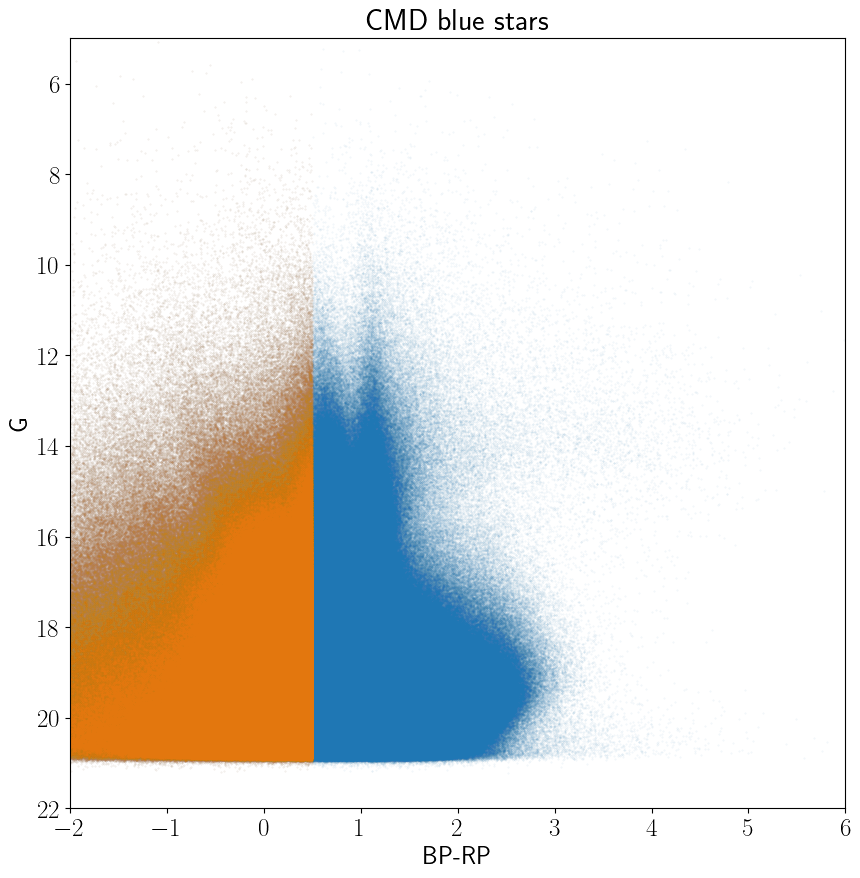

In [13]:
# plot the color-magnitude diagram of the stars in the sample after the selection algorithm
plt.figure(figsize=(10, 10))
plt.scatter(data['bp_rp_corr'], data['phot_g_mean_mag'], s=0.1, alpha = 0.1, label='All stars')
plt.scatter(data_f['bp_rp_corr'], data_f['phot_g_mean_mag'], s=0.1, alpha = 0.1, label='Blue stars')
plt.gca().invert_yaxis()
plt.xlabel('BP-RP')
plt.ylabel('G')
plt.xlim(-2,6)
plt.ylim(22, 5)
plt.title('CMD blue stars')
plt.show()


### $\overline{\omega}_I - \overline{\omega}_{Gaia} < 2 \sigma$

In [14]:
# check the consistency of the parallax
print('Checking parallax consistency')
parallax_consistency_bol = parallax_consistency(data_f['parallax'], data_f['parallax_error'], 
                                data_f['implied_parallax'], data_f['implied_parallax_error'])

# keep only consistent parallaxes
data_f = data_f[parallax_consistency_bol]
print('Number of consistent parallaxes:', len(data_f))

Checking parallax consistency
Number of consistent parallaxes: 1888916


<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:4: SyntaxWarning: invalid escape sequence '\o'
/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_98680/863109276.py:4: SyntaxWarning: invalid escape sequence '\o'
  plt.scatter(data_f['parallax'], data_f['implied_parallax'], s=0.1, alpha = 0.5, label = '$$\overline{\omega}_I - \overline{\omega}_{Gaia} < 2 \sigma$$')


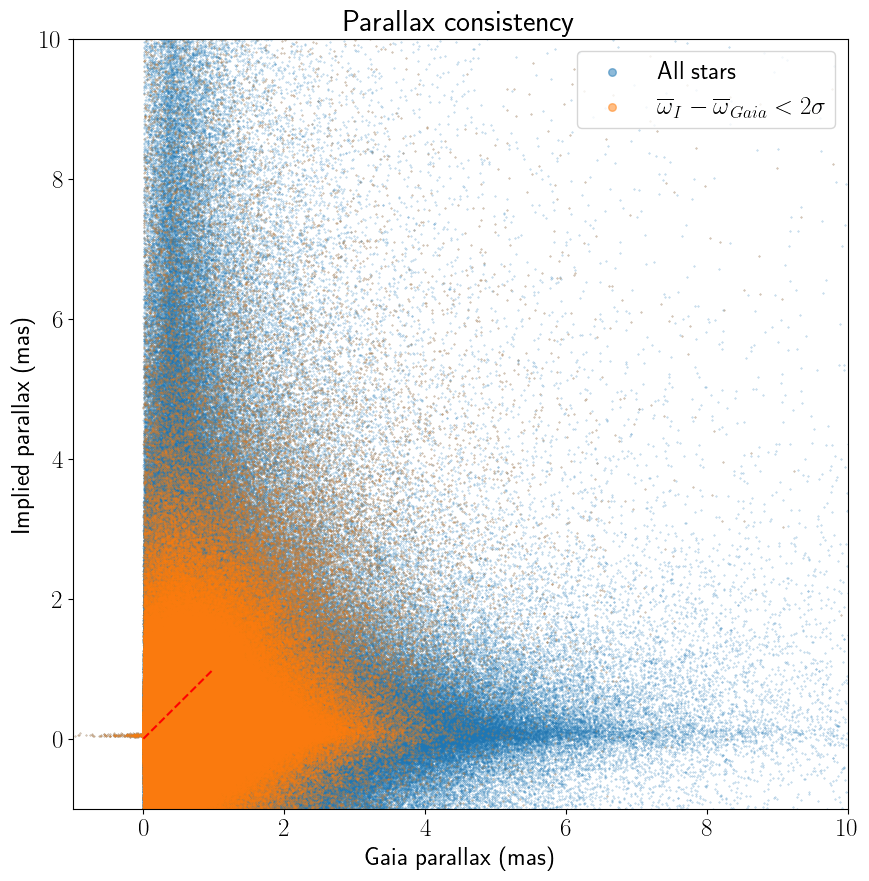

In [15]:
# plot Gaia parallax vs implied parallax
plt.figure(figsize=(10, 10))
plt.scatter(data['parallax'], data['implied_parallax'], s=0.1, alpha = 0.5, label = 'All stars')
plt.scatter(data_f['parallax'], data_f['implied_parallax'], s=0.1, alpha = 0.5, label = '$$\overline{\omega}_I - \overline{\omega}_{Gaia} < 2 \sigma$$')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim(-1, 10)
plt.ylim(-1,10 )
plt.xlabel('Gaia parallax (mas)')
plt.ylabel('Implied parallax (mas)')
plt.title('Parallax consistency')
# set legend handles marker size
# Create the legend
legend = plt.legend(loc='upper right', fontsize=18)
legend.legend_handles[0]._sizes = [30]
legend.legend_handles[1]._sizes = [30]

plt.show()


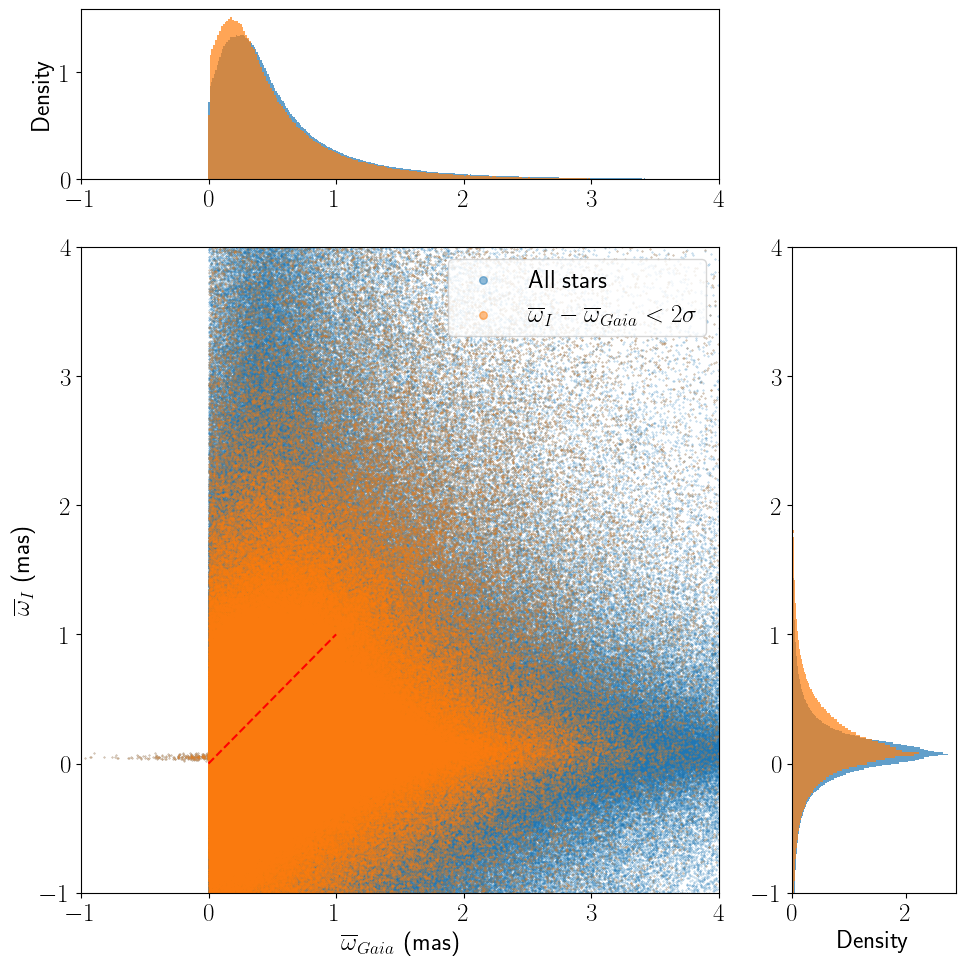

In [16]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


# Create the main figure and the GridSpec
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 4, figure=fig)

# Main scatter plot
ax_main = fig.add_subplot(gs[1:4, 0:3])
sc1 = ax_main.scatter(data['parallax'], data['implied_parallax'], s=0.1, alpha=0.5, label='All stars')
sc2 = ax_main.scatter(data_f['parallax'], data_f['implied_parallax'], s=0.1, alpha=0.5, label=r'$\overline{\omega}_I - \overline{\omega}_{Gaia} < 2 \sigma$')
ax_main.plot([0, 1], [0, 1], 'r--')
ax_main.set_xlim(-1, 4)
ax_main.set_ylim(-1, 4)
ax_main.set_xlabel(r'$\overline{ \omega}_{Gaia}$ (mas)')
ax_main.set_ylabel(r'$\overline{ \omega}_{I}$ (mas)')
#ax_main.set_title('Implied parallax over error limit')

# Create the legend
legend = ax_main.legend(loc='upper right', fontsize=18)
legend.legend_handles[0]._sizes = [30]
legend.legend_handles[1]._sizes = [30]

# Histogram for the X-axis (top)
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
ax_histx.hist(data[np.abs(data['implied_parallax'])< 4]['parallax'], bins='scott', alpha=0.7, density= True)
ax_histx.hist(data_f[np.abs(data_f['implied_parallax'])< 4]['parallax'], bins='scott', alpha=0.7, density= True)
ax_histx.set_xlim(ax_main.get_xlim())
ax_histx.axis('on')  # Hide axis for the histogram
ax_histx.set_ylabel('Density')

# Histogram for the Y-axis (right)
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_main)
ax_histy.hist(data[np.abs(data['implied_parallax'])< 4]['implied_parallax'], bins='scott', orientation='horizontal', alpha=0.7, density=  True)
ax_histy.hist(data_f[np.abs(data_f['implied_parallax'])< 4]['implied_parallax'], bins='scott' , orientation='horizontal', alpha=0.7, density=  True)
ax_histy.set_ylim(ax_main.get_ylim())
ax_histy.axis('on')  # Hide axis for the histogram
ax_histy.set_xlabel('Density')

# Adjust layout to remove overlaps
plt.tight_layout()

plt.show()



### $\frac{\overline{\omega}_I}{\sigma_{\overline{\omega}_I}} > 5$ 

In [17]:
# check if the parallax over error is good
print('Checking if the parallax is good')
data_f = data_f[good_parallax(np.abs(data_f['implied_parallax']), data_f['implied_parallax_error'])]
print('Number of implied parallax_over_error > 5:', len(data_f))

Checking if the parallax is good
Number of implied parallax_over_error > 5: 403191


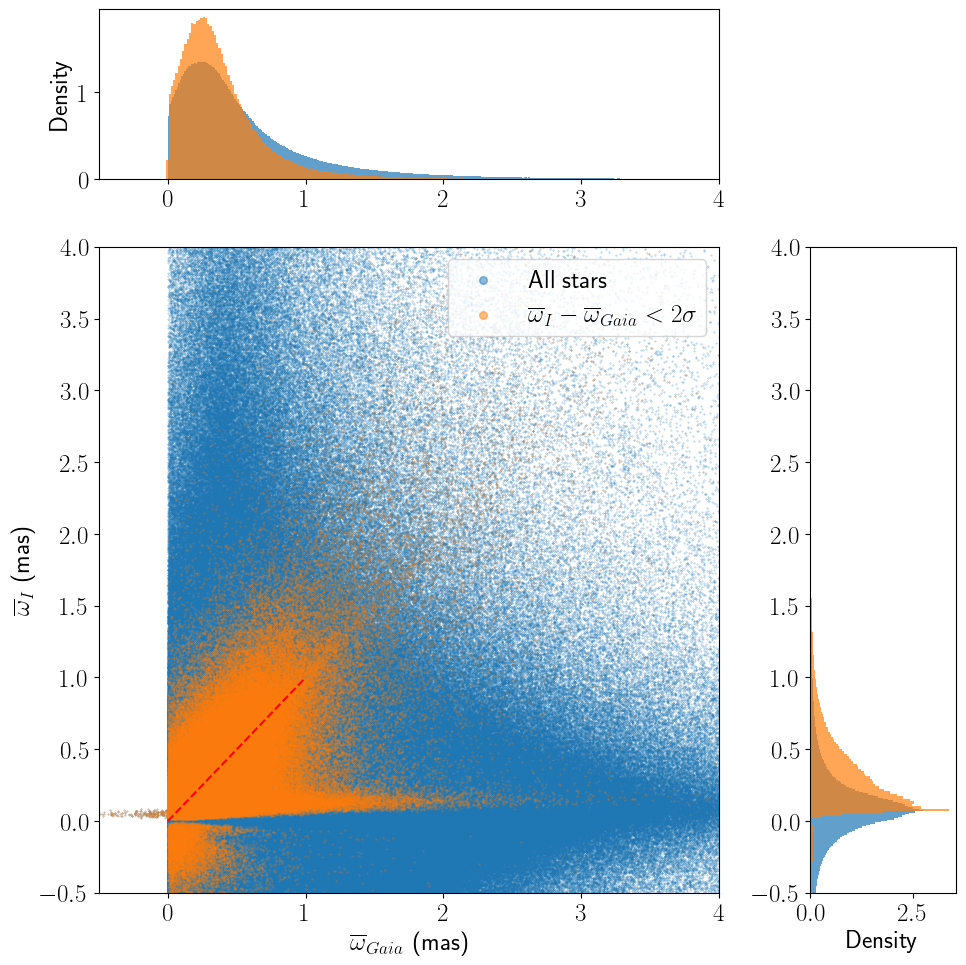

In [18]:

# Create the main figure and the GridSpec
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 4, figure=fig)

# Main scatter plot
ax_main = fig.add_subplot(gs[1:4, 0:3])
sc1 = ax_main.scatter(data['parallax'], data['implied_parallax'], s=0.1, alpha=0.5, label='All stars')
sc2 = ax_main.scatter(data_f['parallax'], data_f['implied_parallax'], s=0.1, alpha=0.5, label=r'$\overline{\omega}_I - \overline{\omega}_{Gaia} < 2 \sigma$')
ax_main.plot([0, 1], [0, 1], 'r--')
ax_main.set_xlim(-0.5, 4)
ax_main.set_ylim(-0.5, 4)
ax_main.set_xlabel(r'$\overline{ \omega}_{Gaia}$ (mas)')
ax_main.set_ylabel(r'$\overline{ \omega}_{I}$ (mas)')
#ax_main.set_title('Implied parallax over error limit')

# Create the legend
legend = ax_main.legend(loc='upper right', fontsize=18)
legend.legend_handles[0]._sizes = [30]
legend.legend_handles[1]._sizes = [30]

# Histogram for the X-axis (top)
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
ax_histx.hist(data[np.abs(data['implied_parallax'])< 4]['parallax'], bins='scott', alpha=0.7, density= True)
ax_histx.hist(data_f[np.abs(data_f['implied_parallax'])< 4]['parallax'], bins='scott', alpha=0.7, density= True)
ax_histx.set_xlim(ax_main.get_xlim())
ax_histx.axis('on')  # Hide axis for the histogram
ax_histx.set_ylabel('Density')

# Histogram for the Y-axis (right)
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_main)
ax_histy.hist(data[np.abs(data['implied_parallax'])< 4]['implied_parallax'], bins='scott', orientation='horizontal', alpha=0.7, density=  True)
ax_histy.hist(data_f[np.abs(data_f['implied_parallax'])< 4]['implied_parallax'], bins='scott' , orientation='horizontal', alpha=0.7, density=  True)
ax_histy.set_ylim(ax_main.get_ylim())
ax_histy.axis('on')  # Hide axis for the histogram
ax_histy.set_xlabel('Density')

# Adjust layout to remove overlaps
plt.tight_layout()

plt.show()


### $800 < V_I < 3500 km s^{-1}$

In [19]:
# check if the star is fast
print('Checking if the star is fast')
data_f = data_f[is_fast(data_f['VGCR'])] # could be changed to VR if needed
print('Number of fast stars:', len(data_f))

Checking if the star is fast
Number of fast stars: 16557


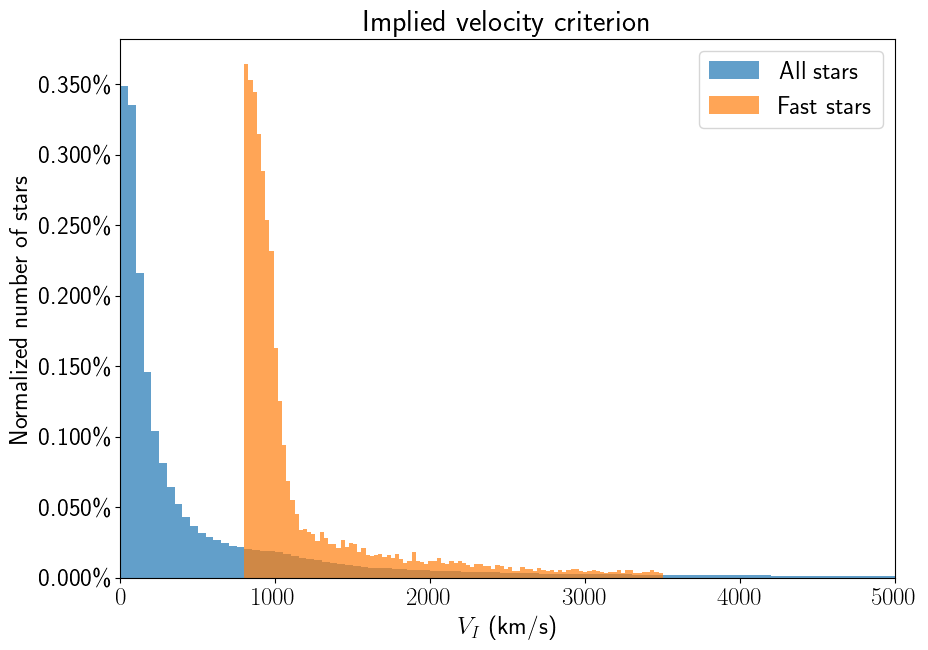

In [20]:
from matplotlib.ticker import PercentFormatter
# plot implied velocity histogram
plt.figure(figsize=(10, 7))
plt.hist(data[(data['VGCR']< 5000) & (data['VGCR']> 0)]['VGCR'], bins=100, alpha=0.7, label='All stars', density= True)
plt.hist(data_f['VGCR'], bins=100, alpha=0.7, label='Fast stars', density= True)
plt.xlabel('$V_I$ (km/s)')
plt.ylabel('Normalized number of stars')
plt.title('Implied velocity criterion')
plt.xlim(0, 5000)
# show y axis ticks as percentage times 1e-2
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.show()


### $\texttt{RUWE} < 1.4$

This is implemented in the query, but if we check we can see that this removes on of the 600 candidates, source id 1636042515805110273, which has a $\texttt{RUWE} = 2.143628$

In [21]:
# check if the astrometry is decent
print('Checking if the astrometry is decent')
# keep only decent astrometry
data_f = data_f[decent_astrometry(data_f['ruwe'])]
print('Number of stars with decent astrometry:', len(data_f))


Checking if the astrometry is decent
Number of stars with decent astrometry: 16556


In [22]:
# how many stars are left
print('Number of stars left:', len(data_f))
print('This corresponds to:', len(data_f)/len(data)*100, '% of the original sample')

Number of stars left: 16556
This corresponds to: 0.16555006699598024 % of the original sample


The effect of this is that now the parallax consistency actually works now that we made sure that both the implied and gaia astrometry are good

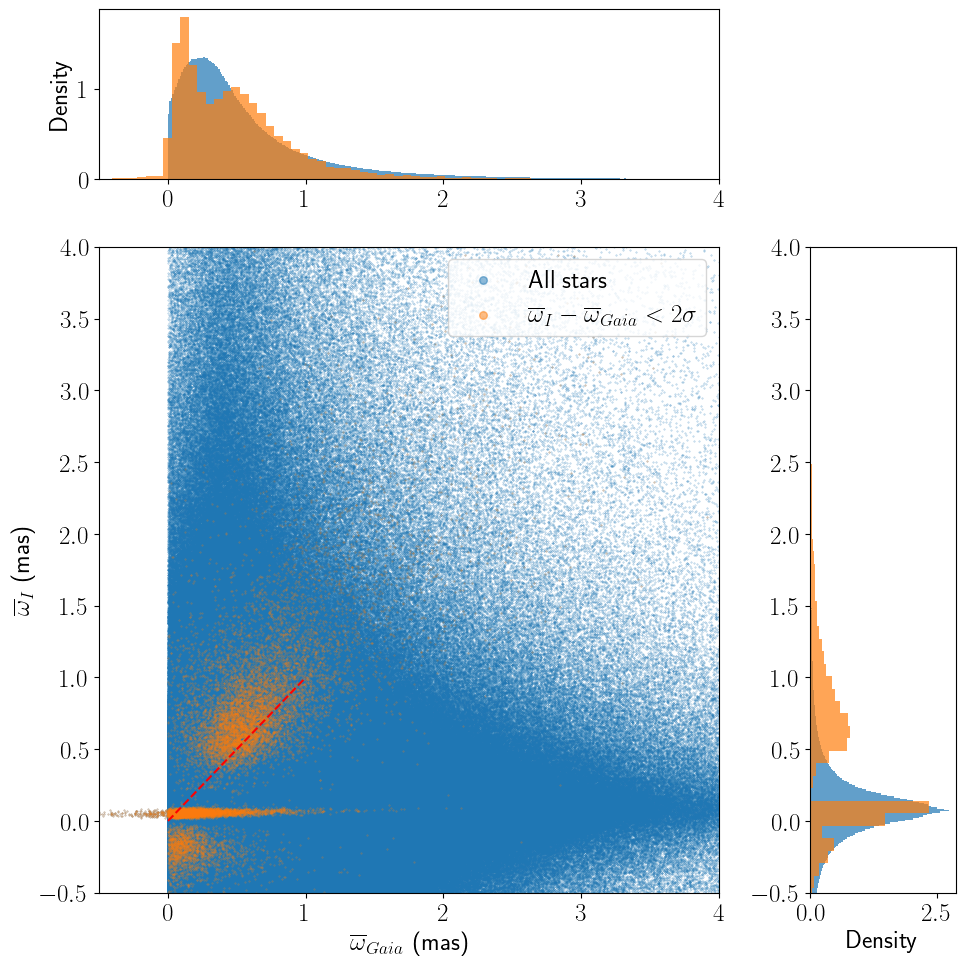

In [23]:

# Create the main figure and the GridSpec
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 4, figure=fig)

# Main scatter plot
ax_main = fig.add_subplot(gs[1:4, 0:3])
sc1 = ax_main.scatter(data['parallax'], data['implied_parallax'], s=0.1, alpha=0.5, label='All stars')
sc2 = ax_main.scatter(data_f['parallax'], data_f['implied_parallax'], s=0.1, alpha=0.5, label=r'$\overline{\omega}_I - \overline{\omega}_{Gaia} < 2 \sigma$')
ax_main.plot([0, 4], [0, 4], 'r--')
ax_main.set_xlim(-0.5, 4)
ax_main.set_ylim(-0.5, 4)
ax_main.set_xlabel(r'$\overline{ \omega}_{Gaia}$ (mas)')
ax_main.set_ylabel(r'$\overline{ \omega}_{I}$ (mas)')
#ax_main.set_title('Implied parallax over error limit')

# Create the legend
legend = ax_main.legend(loc='upper right', fontsize=18)
legend.legend_handles[0]._sizes = [30]
legend.legend_handles[1]._sizes = [30]

# Histogram for the X-axis (top)
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
ax_histx.hist(data[np.abs(data['implied_parallax'])< 4]['parallax'], bins='scott', alpha=0.7, density= True)
ax_histx.hist(data_f[np.abs(data_f['implied_parallax'])< 4]['parallax'], bins='scott', alpha=0.7, density= True)
ax_histx.set_xlim(ax_main.get_xlim())
ax_histx.axis('on')  # Hide axis for the histogram
ax_histx.set_ylabel('Density')

# Histogram for the Y-axis (right)
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_main)
ax_histy.hist(data[np.abs(data['implied_parallax'])< 4]['implied_parallax'], bins='scott', orientation='horizontal', alpha=0.7, density=  True)
ax_histy.hist(data_f[np.abs(data_f['implied_parallax'])< 4]['implied_parallax'], bins='scott' , orientation='horizontal', alpha=0.7, density=  True)
ax_histy.set_ylim(ax_main.get_ylim())
ax_histy.axis('on')  # Hide axis for the histogram
ax_histy.set_xlabel('Density')

# Adjust layout to remove overlaps
plt.tight_layout()

plt.show()


We get mostly two types of sources, ones with parallax very close to zero that pass because the error is very high, and ones that pass because the parallax is actually similar to the implied parallax. The second sample is much more interesting

### $ D_I - D_{BJ} < 2 \sigma $ 

In [24]:

    # check the consistency of the distance, note that if querying from Gaia database this must change as column names are different
    print('Checking distance consistency')

    #data['distance_consistency'] = distance_consistency(data['implied_distance'], data['r_med_geo'], data['implied_distance_error'], (data['r_lo_geo'] - data['r_hi_geo']))
    #distance_consistency_mask = distance_consistency_sill(data['implied_distance'], data['implied_distance_error'],
    #                                                        data['r_med_photogeo'], data['r_lo_photogeo'],
    #                                                        data['r_hi_photogeo'], sigma = 2)

    distance_consistency_mask = distance_consistency_sill_parallax(data_f['implied_parallax'], data_f['implied_parallax_error'],
                                                                    data_f['r_med_photogeo'], data_f['r_lo_photogeo'],
                                                                    data_f['r_hi_photogeo'], sigma = 2)
    # keep only consistent distances
    data_f = data_f[distance_consistency_mask]
    print('Number of consistent distances:', len(data_f))

Checking distance consistency
Number of consistent distances: 5009


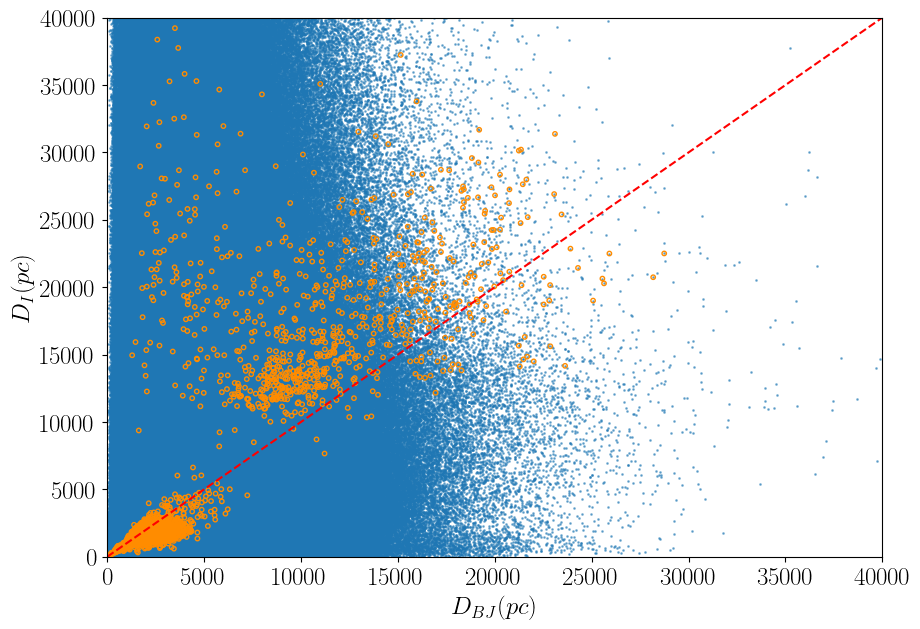

In [39]:
# plot distance consistency
plt.figure(figsize=(10, 7))
plt.scatter(data['r_med_photogeo'], data['implied_distance'], s=1, alpha = 0.5, label='All stars')
plt.scatter(data_f['r_med_photogeo'], data_f['implied_distance'], s=10, alpha = 1, label='Consistent distances', marker='o', facecolors='none', edgecolors='darkorange')
plt.plot([0, 5e4], [0, 5e4], 'r--')
plt.xlim(0, 4e4)
plt.ylim(0, 4e4)
# Create the legend
legend = ax_main.legend(loc='upper right', fontsize=18)

for lh in legend.legend_handles:
    lh._sizes = [30]
plt.xlabel(r'$D_{BJ} (pc)$')
plt.ylabel(r'$D_I (pc)$ ')

plt.show()

### $A_G < 1.5$

In [40]:
# check if the star is affected by extinction
print('Checking if the star is heavily affected by extinction') 
# keep only stars not affected by extinction
data_f = data_f[check_extinction(data_f['A_G'])]
print('Number of stars not affected by extinction:', len(data_f))

Checking if the star is heavily affected by extinction
Number of stars not affected by extinction: 731


This criteria takes out extinct regions, ie some of the galactic disk and the galactic center

In [ ]:
# galactic coordinates mollwide plot
plt.figure(figsize=(10, 7))
plt.scatter(data['l'], data['b'], s=1, alpha = 0.5, label='All stars')
plt.scatter(data_f['l'], data_f['b'], s=10, alpha = 1, label='Not affected by extinction', marker='o', facecolors='none', edgecolors='darkorange')
plt.xlabel('l')
plt.ylabel('b')
plt.title('Galactic coordinates')
plt.legend()
plt.show()

/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


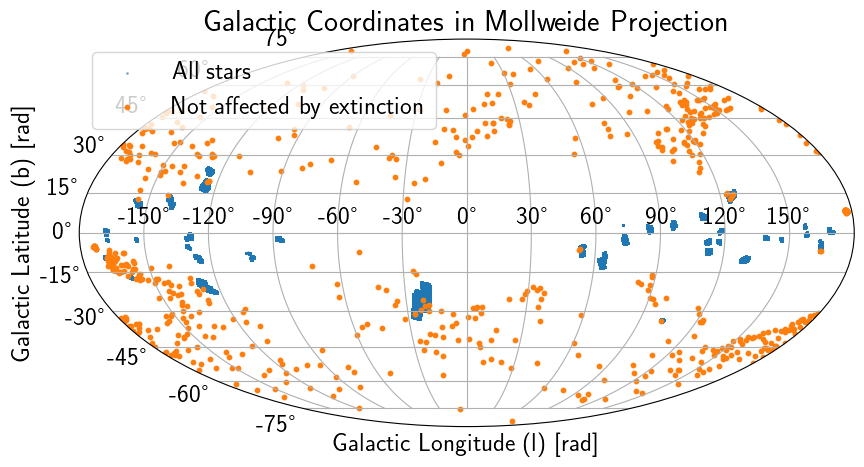

In [42]:
# Convert degrees to radians for Mollweide projection
data['l_rad'] = np.radians(data['l'] - 180)  # Shift l by 180 degrees for better centralization in Mollweide projection
data['b_rad'] = np.radians(data['b'])
data_f['l_rad'] = np.radians(data_f['l'] - 180)
data_f['b_rad'] = np.radians(data_f['b'])

# Create the Mollweide projection plot
plt.figure(figsize=(10, 7))
ax = plt.subplot(111, projection='mollweide')

# Scatter plot for all stars
ax.scatter(data['l_rad'], data['b_rad'], s=1, alpha=0.5, label='All stars')

# Scatter plot for stars not affected by extinction
ax.scatter(data_f['l_rad'], data_f['b_rad'], s=10, alpha=1, label='Not affected by extinction')

# Set labels and title
ax.set_xlabel('Galactic Longitude (l) [rad]')
ax.set_ylabel('Galactic Latitude (b) [rad]')
ax.set_title('Galactic Coordinates in Mollweide Projection')

# Add legend
plt.legend()

# Adjust ticks and display plot
ax.grid(True)
plt.show()